# Analytical Decision Making - Portfolio Management
##### Zimei Yang | June 2, 2018

The objective is to consider different approaches with respect to portfolio optimization. In the data set, we have trading information about 6 stocks. Based on the evolution of these stocks, we'll recommend different portfolio allocations.

## Part A: Portfolio Management Based on the Full Dataset

### Portfolio:
We implement an portfolio optimization problem for tech companies, i.e.,

* Amazon

* Apple 

* eBay

* Facebook

* Google

* Twitter

Find out what is the optimal
allocation 𝑥 = {𝑥1, 𝑥2, 𝑥3, 𝑥4, 𝑥5, 𝑥6}  of these 6 stocks.

#### *The goal is to minimize risk and maximize returns.*










## 1. Preparing the data

In [128]:
# install packages
!pip install xlrd
!pip install cvxpy==0.4.11

In [0]:
# import packages
import numpy as np
from numpy import matrix
import pandas as pd
import math
import cvxpy as cvx
from cvxpy import *
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize

In [130]:
# upload data
from google.colab import files
files.upload()  # choose file "datahomework2.xls" from computer

{}

In [131]:
# read data into dataframe
df=pd.read_excel("datahomework2.xls")
df.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter
0,252.585,106.250000,23.457600,77.190002,519.500000,36.380001
1,245.488,106.260002,23.156700,76.150002,506.600006,37.279999
2,253.816,107.750000,23.116699,76.150002,505.200012,39.090000
3,256.030,111.889999,23.741699,78.175003,506.899994,40.169998
4,253.299,112.010002,23.413401,77.739998,500.700012,39.369999


In [132]:
# see dimension of the full data set --- 800 days of data for 6 stokcs
df.shape

(799, 6)

### A. Compute the rate of returns for each stock

In [133]:
df_returns = pd.DataFrame(index=range(len(df)-1), columns=[["Amazon","Apple", "Ebay","Facebook","Google","Twitter"]], dtype=float)

for i in range(6):
    for t in range(len(df)-1):
        df_returns.iloc[t][i] = (df.iloc[t+1][i]-df.iloc[t][i])/df.iloc[t][i]
        
df_returns.head()

,Amazon,Apple,Ebay,Facebook,Google,Twitter
0,-0.028097,0.000094,-0.012827,-0.013473,-0.024832,0.024739
1,0.033924,0.014022,-0.001727,0.000000,-0.002764,0.048552
2,0.008723,0.038422,0.027037,0.026592,0.003365,0.027628
3,-0.010667,0.001073,-0.013828,-0.005565,-0.012231,-0.019915
4,-0.028460,-0.024641,-0.007726,-0.013121,-0.007190,0.007112


### B. Compute the average return that will use in the optimization

In [134]:
returns = df_returns + 1 
geometric_mean = stats.gmean(returns.iloc[:, 0:6], axis = 0)
mu = geometric_mean-1  
mu

array([ 1.98778605e-03,  6.25712685e-04,  7.54726158e-04,  1.08819147e-03,
        9.73603071e-04, -2.78636077e-05])

### C. Compute the variance-covariance matrix of the stock returns

In [0]:
covariance = []

for i in range(6):
    for j in range(6):
        covariance.append(  sum(  (df_returns.iloc[:,i]- mu[i]) * (df_returns.iloc[:,j] - mu[j])  )/  len(df_returns)  )
        
Cov = np.asarray(covariance).reshape((6,6))

### D. Provide the vector 𝜇 and the variance-covariance matrix 𝛴 for the 6 assets considered.

In [136]:
print("vector 𝜇 :", mu)
print("variance-covariance matrix 𝛴 :", Cov)

vector 𝜇 : [ 1.98778605e-03  6.25712685e-04  7.54726158e-04  1.08819147e-03
  9.73603071e-04 -2.78636077e-05]
variance-covariance matrix 𝛴 : [[ 4.06726597e-04  4.62385509e-06  1.22907272e-05 -1.05296935e-05
   6.57882666e-06 -9.47880356e-05]
 [ 4.62385509e-06  2.10550652e-04  5.98771009e-05  6.93741999e-05
   6.00324610e-05  4.03738159e-05]
 [ 1.22907272e-05  5.98771009e-05  2.91691955e-04  2.70917635e-05
   5.45309717e-05  2.44067414e-05]
 [-1.05296935e-05  6.93741999e-05  2.70917635e-05  2.42074700e-04
   9.88492704e-05  2.19647432e-05]
 [ 6.57882666e-06  6.00324610e-05  5.45309717e-05  9.88492704e-05
   2.02597988e-04  9.69833772e-06]
 [-9.47880356e-05  4.03738159e-05  2.44067414e-05  2.19647432e-05
   9.69833772e-06  1.07017537e-03]]


## 2. Minimizing Risk

The goal is to find an optimal allocation 𝑥 = {𝑥1, 𝑥2, 𝑥3, 𝑥4, 𝑥5, 𝑥6} that minimizes risk of the portfolio with a constraint on the minimum returns:
 
 
 
\begin{align}
\text{Minimize} \quad \frac{1}{2} x^T & \Sigma x\\
\text{Subject to}\quad \mu^T x &\geq R\\
\sum_{i=1}^6x_i&=1\\
x&\geq0
\end{align}


where R is the annual return that the investor wants to achieve, with 𝑅 = 0.07.

In [0]:
# R is the annual return that the investor wants to achieve, with 𝑅 = 0.07
# stock market operates 250 days a year
R=0.07/250

# 6 stocks  
x=cvx.Variable(6)

In [0]:
risk=quad_form(x, Cov)
rr=sum_entries(mu*x)

In [139]:
prob1 = Problem(Minimize(risk), 
               [rr>=R,
                sum_entries(x) == 1, 
                x >= 0])
prob1.solve()
print(x.value)

[[0.20423419]
 [0.19553757]
 [0.16169524]
 [0.1737625 ]
 [0.18989799]
 [0.0748725 ]]


In [140]:
df.columns

Index(['Amazon', 'Apple', 'Ebay', 'Facebook', 'Google', 'Twitter'], dtype='object')

## 3. Maximizing Returns (Utility)

Another approach to portfolio optimization is to optimize the expected returns that the portfolio would give while penalizing for volatility (variance). Specifically, find out what is the
allocation 𝑥 = {𝑥1, 𝑥2, 𝑥3, 𝑥4, 𝑥5, 𝑥6} that solve the following optimization problem


\begin{align} 
\text{Maximize}\quad \ 𝜇^T x  - 𝛾 * sqrt(x^T  & \Sigma x)\\
\text{Subject to}\quad \sum_{i=1}^6x_i&=1\\
x&\geq0
\end{align}


where 𝛾 is the risk aversion coefficient of the investor. Report the optimal allocations for 𝛾 = 0.1, 𝛾 = 0.15 and 𝛾 = 0.2, as well as the value of the objective function. 

In [0]:
# turn vector 𝜇 into matrix
mu = np.asmatrix(mu)

# define variable matrix
x_mat = matrix([0,0,0,0,0,0])

#define bounds
bounds = ((0,None),(0,None),(0,None),(0,None),(0,None),(0,None))

In [0]:
# define objective functions ---- returns with 𝛾 = 0.1, 𝛾 = 0.15 and 𝛾 = 0.2
# 𝛾 = 0.1
def return1(x):
    return -(x.T * mu.T-0.1*np.sqrt(np.dot(np.dot(x.T,Cov),x)))
  
# 𝛾 = 0.15
def return15(x):
    return -(x.T * mu.T-0.15*np.sqrt(np.dot(np.dot(x.T,Cov),x)))
  
# 𝛾 = 0.2
def return2(x):
    return -(x.T * mu.T-0.2*np.sqrt(np.dot(np.dot(x.T,Cov),x)))

In [0]:
# solve the optimization problem using scipy.optimize.minimize 

allocation1 = minimize(return1, 
                       x_mat, 
                       constraints = ({'type':'eq','fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]-1}),
                       bounds = bounds,)

allocation15 = minimize(return15, 
                       x_mat, 
                       constraints = ({'type':'eq','fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]-1}),
                       bounds = bounds,)

allocation2 = minimize(return2, 
                       x_mat, 
                       constraints = ({'type':'eq','fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]-1}),
                       bounds = bounds,)

In [144]:
# see allocations
print("When 𝛾 = 0.1 the optimal allocation is", allocation1.x)
print("When 𝛾 = 0.15 the optimal allocation is", allocation15.x)
print("When 𝛾 = 0.2 the optimal allocation is", allocation2.x)

When 𝛾 = 0.1 the optimal allocation is [0.29673507 0.15517325 0.16262406 0.19665145 0.18881617 0.        ]
When 𝛾 = 0.15 the optimal allocation is [0.28018167 0.16294494 0.16697884 0.19507088 0.18997784 0.00484583]
When 𝛾 = 0.2 the optimal allocation is [0.25909832 0.16777295 0.16933456 0.19127109 0.1882994  0.02422369]


In [145]:
# see value of the object function
print("When 𝛾 = 0.1 the value of objective function is", -allocation1.fun)
print("When 𝛾 = 0.15 the value of objective function is", -allocation15.fun)
print("When 𝛾 = 0.2 the value of objective function is", -allocation2.fun)

When 𝛾 = 0.1 the value of objective function is 0.00026146965846262087
When 𝛾 = 0.15 the value of objective function is -0.00021840172639915568
When 𝛾 = 0.2 the value of objective function is -0.0006831786971098798


In [147]:
col = {'Risk Aversion':['gamma=0.1','gamma=0.15','gamma=0.2'],
     'Amazon': [round(allocation1.x.item(0),4), round(allocation15.x.item(0),4), round(allocation2.x.item(0),4)],
     'Apple': [ round(allocation1.x.item(1),4), round(allocation15.x.item(1),4), round(allocation2.x.item(1),4)],
     'EBay': [round(allocation1.x.item(2),4), round(allocation15.x.item(2),4), round(allocation2.x.item(2),4)],
     'Facebook': [round(allocation1.x.item(3),4), round(allocation15.x.item(3),4), round(allocation2.x.item(3),4)],
     'Google': [round(allocation1.x.item(4),4), round(allocation15.x.item(4),4), round(allocation2.x.item(4),4)],
     'Twitter': [round(allocation1.x.item(5),4), round(allocation15.x.item(5),4), round(allocation2.x.item(5),4)],
     'Optimal Result': [round(-allocation1.fun,4), round(-allocation15.fun,4), round(-allocation2.fun,4)]}

table = pd.DataFrame(col, columns=['Risk Aversion', 'Amazon', 'Apple', 'EBay', 'Facebook', 'Google', 'Twitter', 'Optimal Result'])
table

,Risk Aversion,Amazon,Apple,EBay,Facebook,Google,Twitter,Optimal Result
0,gamma=0.1,0.2967,0.1552,0.1626,0.1967,0.1888,0.0000,0.0003
1,gamma=0.15,0.2802,0.1629,0.1670,0.1951,0.1900,0.0048,-0.0002
2,gamma=0.2,0.2591,0.1678,0.1693,0.1913,0.1883,0.0242,-0.0007


The different allocations are caused by the different level of risk aversion. The less the risk aversion coefficient, the higher risk the investor is willing to take. Therefore, we can see that, when the risk aversion coefficient is at the lowest level, 0.1, the optimal allocation is to focus more on the stocks with high returns and invest in these stocks with higher risks but also higher returns, such as Amazon and Facebook, and avoid stocks with low returns even though they’re less risky, like Twitter. Contrarily, when the risk aversion coefficient is at the highest level here, 0.2, the optimal allocation is to invest more diversely on multiple assets, invest less on highly risky stocks even if they might bring higher returns, such as Amazon and Facebook, and increase investment on stocks that are less risky, like Twitter and eBay.

## 4. Simulations
Based on the optimal allocations 𝑥∗ obtained in the two questions above, 𝜇 and 𝛴,  simulate the value of your portfolio after 300 trading days assuming that we have invested $100,000.
* Report the mean and the variance of the portfolio in a table
* Provide visualizations of your results.

In [0]:
simu = 200  # we are doing 250 simulations
T = 300  # 300 trading days
m = 6  # we have # 6 assets
B = 100000  # Budget is $100,000
mu1 = mu.tolist()[0] # tranform the mu matrix to a vector

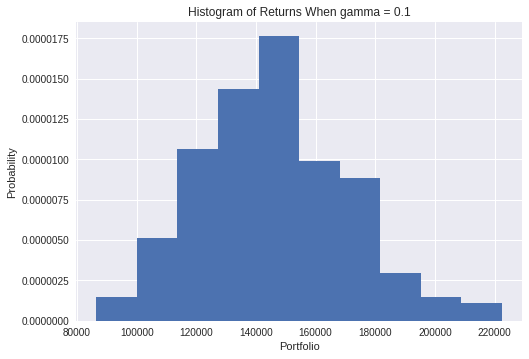

In [99]:
# When 𝛾 = 0.1
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0]=[allocation1.x.item(0), allocation1.x.item(1), allocation1.x.item(2),
          allocation1.x.item(3), allocation1.x.item(4), allocation1.x.item(5)]
    for i in range(T):
        rr=np.random.multivariate_normal(mu1,Cov)  
        y[i+1]=y[i]*(1+rr)
    z_values.append(sum(y[T])*B)
        
mean1 = np.mean(z_values)
var1 = np.var(z_values)

plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns When gamma = 0.1')
plt.show()

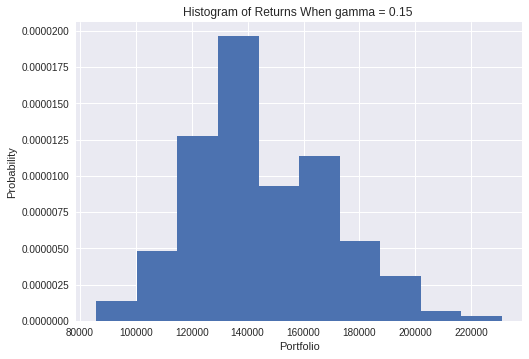

In [101]:
# When 𝛾 = 0.15
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0]=[allocation15.x.item(0), allocation15.x.item(1), allocation15.x.item(2),
          allocation15.x.item(3), allocation15.x.item(4), allocation15.x.item(5)]
    for i in range(T):
        rr=np.random.multivariate_normal(mu1,Cov)
        y[i+1]=y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

mean15 = np.mean(z_values)
var15 = np.var(z_values)

plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns When gamma = 0.15 ')
plt.show()

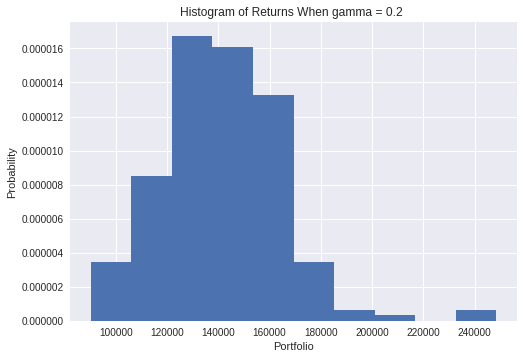

In [102]:
# When 𝛾 = 0.2
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0]=[allocation2.x.item(0), allocation2.x.item(1), allocation2.x.item(2), 
          allocation2.x.item(3), allocation2.x.item(4), allocation2.x.item(5)]
    for i in range(T):
        rr=np.random.multivariate_normal(mu1,Cov)
        y[i+1]=y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

mean2 = np.mean(z_values)
var2 = np.var(z_values)

plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns When gamma = 0.2 ')
plt.show()

In [103]:
col = {'Level of Risk Aversion':['gamma=0.1','gamma=0.15','gamma=0.2'],
     'Mean of Portfolio':[mean1, mean15, mean2],
     'Variance of Portfolio':[var1, var15, var2]}

table = pd.DataFrame(col, columns=['Level of Risk Aversion','Mean of Portfolio','Variance of Portfolio'])
table

,Level of Risk Aversion,Mean of Portfolio,Variance of Portfolio
0,gamma=0.1,145704.241382,6.285100e+08
1,gamma=0.15,145231.202361,6.248604e+08
2,gamma=0.2,140916.485884,5.514608e+08


We can see in the simulation result, in general, the more risky allocation strategy brings higher returns while having a higher variance; the less risky allocation strategy brings lower returns while having a lower variance.



-------------

## PART B -  Portfolio Optimization based on the last 400 trading days.
Redo Part A taking into account the last 400 trading days only.

## 1. Preparing the Data

In [104]:
# select the last 400 trading days
df = df[-400:]
df.head() 

,Amazon,Apple,Ebay,Facebook,Google,Twitter
399,687.181,105.870003,31.059999,124.360001,797.250000,19.540001
400,676.851,107.480003,31.389999,125.150002,806.929993,20.860001
401,674.919,108.370003,31.150000,125.260002,805.229980,20.400000
402,685.267,108.809998,31.110001,125.059998,807.479980,20.170000
403,691.066,108.000000,31.120001,124.879997,808.489990,19.000000


In [30]:
df.shape

(400, 6)

### E. Compute the rate of returns for each stock

In [106]:
df_returns = pd.DataFrame(index=range(len(df)-1), columns=[["Amazon","Apple", "EBay","Facebook","Google","Twitter"]], dtype=float)

for i in range(6):
    for t in range(len(df)-1):
        df_returns.iloc[t][i] = (df.iloc[t+1][i]-df.iloc[t][i])/df.iloc[t][i]
        
df_returns.head()

,Amazon,Apple,EBay,Facebook,Google,Twitter
0,-0.015032,0.015207,0.010625,0.006353,0.012142,0.067554
1,-0.002854,0.008281,-0.007646,0.000879,-0.002107,-0.022052
2,0.015332,0.004060,-0.001284,-0.001597,0.002794,-0.011274
3,0.008462,-0.007444,0.000321,-0.001439,0.001251,-0.058007
4,-0.000682,-0.000648,0.002571,0.000160,-0.000359,-0.001053


### F. Compute the average return that will use in the optimization

In [107]:
returns = df_returns + 1 
geometric_mean = stats.gmean(returns.iloc[:, 0:6], axis = 0)
mu = geometric_mean-1  
mu

array([0.0014643 , 0.00126081, 0.00080563, 0.00098042, 0.0008732 ,
       0.00150318])

### G. Compute the variance-covariance matrix of the stock returns

In [0]:
covariance = []

for i in range(6):
    for j in range(6):
        covariance.append(  sum(  (df_returns.iloc[:,i]- mu[i]) * (df_returns.iloc[:,j] - mu[j])  )/  len(df_returns)  )
        
Cov = np.asarray(covariance).reshape((6,6))

### H. Provide the vector 𝜇 and the variance-covariance matrix 𝛴 for the 6 assets considered.

In [34]:
print("vector 𝜇 :", mu)
print("variance-covariance matrix 𝛴 :", Cov)

vector 𝜇 : [0.0014643  0.00126081 0.00080563 0.00098042 0.0008732  0.00150318]
variance-covariance matrix 𝛴 : [[ 2.29524929e-04 -9.77415294e-06 -3.52960739e-07 -2.01685925e-06
  -9.22407496e-07 -3.35916745e-05]
 [-9.77415294e-06  1.39371816e-04  6.59006383e-06  2.84220301e-06
   6.90084758e-06 -1.06158004e-05]
 [-3.52960739e-07  6.59006383e-06  2.36168390e-04 -1.31685688e-05
   1.88205114e-06 -2.60729041e-05]
 [-2.01685925e-06  2.84220301e-06 -1.31685688e-05  1.58173966e-04
   2.13322826e-05 -2.29087650e-06]
 [-9.22407496e-07  6.90084758e-06  1.88205114e-06  2.13322826e-05
   1.22191244e-04 -5.27912404e-06]
 [-3.35916745e-05 -1.06158004e-05 -2.60729041e-05 -2.29087650e-06
  -5.27912404e-06  1.00165427e-03]]


## 2. Minimizing Risk

In [0]:
# R is the annual return that the investor wants to achieve, with 𝑅 = 0.07
# stock market operates 250 days a year
R=0.07/250

# 6 stocks  
x=cvx.Variable(6)

In [0]:
risk=quad_form(x, Cov)
rr=sum_entries(mu*x)

In [111]:
prob1 = Problem(Minimize(risk), 
               [rr>=R,
                sum_entries(x) == 1, 
                x >= 0])
prob1.solve()
print(x.value)

[[0.16298367]
 [0.22957664]
 [0.14731106]
 [0.18900859]
 [0.22482549]
 [0.04629455]]


## 3. Maximizing Returns (Utility)

In [0]:
# turn vector 𝜇 into matrix
mu = np.asmatrix(mu)

# define variable matrix
x_mat = matrix([0,0,0,0,0,0])

#define bounds
bounds = ((0,None),(0,None),(0,None),(0,None),(0,None),(0,None))

In [0]:
# define objective functions ---- returns with 𝛾 = 0.1, 𝛾 = 0.15 and 𝛾 = 0.2
# 𝛾 = 0.1
def return1(x):
    return -(x.T * mu.T-0.1*np.sqrt(np.dot(np.dot(x.T,Cov),x)))
  
# 𝛾 = 0.15
def return15(x):
    return -(x.T * mu.T-0.15*np.sqrt(np.dot(np.dot(x.T,Cov),x)))
  
# 𝛾 = 0.2
def return2(x):
    return -(x.T * mu.T-0.2*np.sqrt(np.dot(np.dot(x.T,Cov),x)))

In [0]:
# solve the optimization problem using scipy.optimize.minimize 

allocation1 = minimize(return1, 
                       x_mat, 
                       constraints = ({'type':'eq','fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]-1}),
                       bounds = bounds,)

allocation15 = minimize(return15, 
                       x_mat, 
                       constraints = ({'type':'eq','fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]-1}),
                       bounds = bounds,)

allocation2 = minimize(return2, 
                       x_mat, 
                       constraints = ({'type':'eq','fun':lambda x: x[0]+x[1]+x[2]+x[3]+x[4]+x[5]-1}),
                       bounds = bounds,)

In [41]:
# see allocations
print("When 𝛾 = 0.1 the optimal allocation is", allocation1.x)
print("When 𝛾 = 0.15 the optimal allocation is", allocation15.x)
print("When 𝛾 = 0.2 the optimal allocation is", allocation2.x)

When 𝛾 = 0.1 the opoptimal allocation is [0.22004448 0.21236235 0.15318617 0.17907391 0.17331209 0.06202099]
When 𝛾 = 0.15 the opoptimal allocation is [0.20720483 0.20632554 0.16343431 0.18306182 0.18089577 0.05907773]
When 𝛾 = 0.2 the opoptimal allocation is [0.20169198 0.20415401 0.16789355 0.18510667 0.18463577 0.05651802]


In [124]:
# see value of the object function
print("When 𝛾 = 0.1 the value of objective function is", -allocation1.fun)
print("When 𝛾 = 0.15 the value of objective function is", -allocation15.fun)
print("When 𝛾 = 0.2 the value of objective function is", -allocation2.fun)

When 𝛾 = 0.1 the value of objective function is 0.0005472625519551518
When 𝛾 = 0.15 the value of objective function is 0.00024716726859854625
When 𝛾 = 0.2 the value of objective function is -4.742503465139181e-05


In [125]:
col = {'Risk Aversion':['gamma=0.1','gamma=0.15','gamma=0.2'],
     'Amazon': [round(allocation1.x.item(0),4), round(allocation15.x.item(0),4), round(allocation2.x.item(0),4)],
     'Apple': [ round(allocation1.x.item(1),4), round(allocation15.x.item(1),4), round(allocation2.x.item(1),4)],
     'EBay': [round(allocation1.x.item(2),4), round(allocation15.x.item(2),4), round(allocation2.x.item(2),4)],
     'Facebook': [round(allocation1.x.item(3),4), round(allocation15.x.item(3),4), round(allocation2.x.item(3),4)],
     'Google': [round(allocation1.x.item(4),4), round(allocation15.x.item(4),4), round(allocation2.x.item(4),4)],
     'Twitter': [round(allocation1.x.item(5),4), round(allocation15.x.item(5),4), round(allocation2.x.item(5),4)],
     'Optimal Result': [round(-allocation1.fun,4), round(-allocation15.fun,4), round(-allocation2.fun,4)]}

table = pd.DataFrame(col, columns=['Risk Aversion', 'Amazon', 'Apple', 'EBay', 'Facebook', 'Google', 'Twitter', 'Optimal Result'])
table

,Risk Aversion,Amazon,Apple,EBay,Facebook,Google,Twitter,Optimal Result
0,gamma=0.1,0.2200,0.2124,0.1532,0.1791,0.1733,0.0620,0.0005
1,gamma=0.15,0.2072,0.2063,0.1634,0.1831,0.1809,0.0591,0.0002
2,gamma=0.2,0.2017,0.2042,0.1679,0.1851,0.1846,0.0565,-0.0000


 When the investing period is shortened to 400 days, there are more fluctuations in the market and returns are more unstable and thus lead to higher risk. Therefore, the optimal allocations change accordingly, lower investments in highly risky assets and increase investments in assrts with lower risks.

## 4. Simulations

In [0]:
simu = 200  # we are doing 250 simulations
T = 300  # 300 trading days
m = 6  # we have # 6 assets
B = 100000  # Budget is $100,000
mu1 = mu.tolist()[0] # tranform the mu matrix to a vector

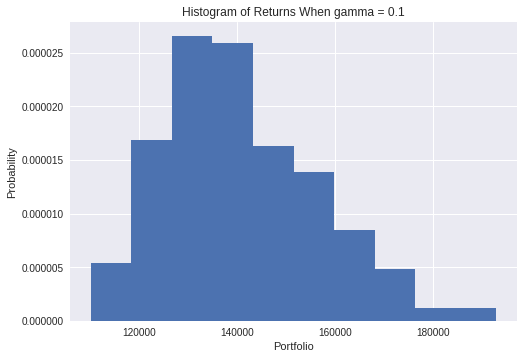

In [116]:
# When 𝛾 = 0.1
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0]=[allocation1.x.item(0), allocation1.x.item(1), allocation1.x.item(2),
          allocation1.x.item(3), allocation1.x.item(4), allocation1.x.item(5)]
    for i in range(T):
        rr=np.random.multivariate_normal(mu1,Cov)  
        y[i+1]=y[i]*(1+rr)
    z_values.append(sum(y[T])*B)
        
mean1 = np.mean(z_values)
var1 = np.var(z_values)

plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns When gamma = 0.1')
plt.show()

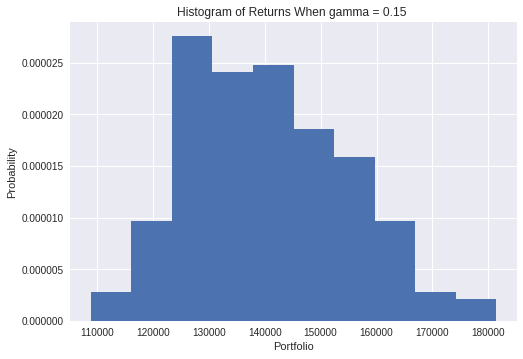

In [122]:
# When 𝛾 = 0.15
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0]=[allocation15.x.item(0), allocation15.x.item(1), allocation15.x.item(2),
          allocation15.x.item(3), allocation15.x.item(4), allocation15.x.item(5)]
    for i in range(T):
        rr=np.random.multivariate_normal(mu1,Cov)
        y[i+1]=y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

mean15 = np.mean(z_values)
var15 = np.var(z_values)

plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns When gamma = 0.15 ')
plt.show()

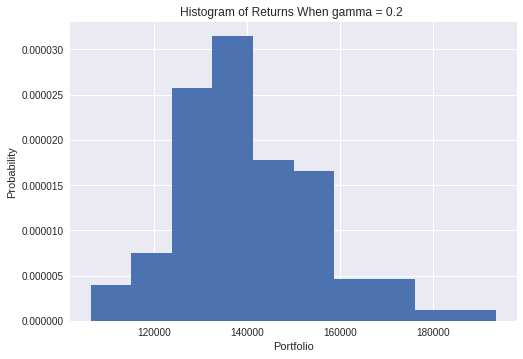

In [118]:
# When 𝛾 = 0.2
z_values = []
for q in range(simu):
    y = np.zeros((T+1,m))
    y[0]=[allocation2.x.item(0), allocation2.x.item(1), allocation2.x.item(2), 
          allocation2.x.item(3), allocation2.x.item(4), allocation2.x.item(5)]
    for i in range(T):
        rr=np.random.multivariate_normal(mu1,Cov)
        y[i+1]=y[i]*(1+rr)
    z_values.append(sum(y[T])*B)

mean2 = np.mean(z_values)
var2 = np.var(z_values)

plt.hist(z_values, density=True )
plt.xlabel('Portfolio')
plt.ylabel('Probability')
plt.title('Histogram of Returns When gamma = 0.2 ')
plt.show()

In [127]:
col = {'Level of Risk Aversion':['gamma=0.1','gamma=0.15','gamma=0.2'],
     'Mean of Returns':[mean1, mean15, mean2],
     'Variance of Portfolio (Risk)':[var1, var15, var2]}

table = pd.DataFrame(col, columns=['Level of Risk Aversion','Mean of Returns','Variance of Portfolio (Risk)'])
table

,Level of Risk Aversion,Mean of Returns,Variance of Portfolio (Risk)
0,gamma=0.1,140933.407301,2.372962e+08
1,gamma=0.15,140711.870999,2.045646e+08
2,gamma=0.2,140021.178881,2.369172e+08


We can see in the simulation result, in general,  the more risky allocation strategy brings higher returns while having a higher variance; the less risky allocation strategy brings lower returns while having a lower variance.